# Stochastic quantization & the harmonic oscillator.

We can use stochastic quantization (real Langevin, if you want) to study quantum mechanics in euclidean time - there is no sign problem. Generally, we're interested in integrals that have the form 

$\mathcal{Z} = \int \mathcal{D}\phi\ e^{-S[\phi]}$

that we call a *path integral* (whatever it may actually be).

### Stochastic quantization in a nutshell.
Now, we can identify the desired probability measure in the path integral as the *equilibrium distribution of a stochastic process*. This process is described by an appropriate Langevin equation:

$\frac{\partial \phi}{\partial t} = \frac{\delta S[\phi]}{\delta \phi} + \eta$,

where $\eta$ is a *gaussian noise term* with $\langle\eta(t)\rangle = 0$ and $\langle\eta(t)\eta(t')\rangle = 2\delta(t-t')$. It is important to notice, that the time $t$ has *nothing* to do with the real time or euclidean time - it is a completely ficticious time (that we call the Langevin time) and can be regarded as the *extra dimension* in which the stochastic process lives. 
The prefactor 2 in the noise term stems from the dissipation-fluctuation theorem and any deviation will result in a wrong random walk. The form of the noise, however, could be anything as long as these two moments are satisfied. 

For the computer, we need to discretize the equation so that we end up with

$\phi_{n+1} = \phi_n - \Delta t\frac{\delta S[\phi]}{\delta \phi} + \sqrt{2\Delta t}\ \eta$.

The sequence $\{\phi_0, \phi_1, \cdots \}$ is then nothing but our Markov chain, that we can then use to obtain averages and uncertainties for our observables. The drawback of this method, as compared to the Metropolis algorithm, is the introduction of this finite integration step $\Delta t$, which introduces a systematic error that needs to be extrapolated.


### The harmonic oscillator.
As a toy problem, we consider the 1D harmonic oscillator, which can be seen as a 0+1 dimensional scalar field theory, since the coordinate is our "field" that only depends on euclidean time.

The action is given by

$S[x] = \int d\tau \left(\frac{1}{2}\frac{\partial x}{\partial \tau}\right)^2 + \frac{1}{2}\omega^2 x^2$

where $m = \hbar = 1$.  To compute the partition function, which we interpret as as path integral over all paths in imaginary time, we need to discretize the time axis with a timestep of $\Delta\tau$. This introduces some systematic error and we have to ensure the correct behavior of our simulation by extrapolating $\Delta\tau \rightarrow 0$ (similar to the Trotter step). The discretized action reads

$S[x] = \sum_{n = 1}^{N_{\tau}} \Delta\tau\left[\frac{1}{2}\left(\frac{x_{n+1} - {x_n}}{\Delta\tau}\right)^2 + \frac{1}{2}\omega^2 x_n^2\right] $

and we can then write down the discretized Langevin equation for the 1D harmonic oscillator:

$x_n^{k+1} = x_n^k\ -\ \Delta t\ \left[\frac{2x_n^k - x_{n-1}^k - x_{n+1}^k}{\Delta\tau} \ +\ \omega^2 x_n^k\right] + \sqrt{2\Delta t}\eta$

where the lower index ($n$) refers to euclidean time and the upper index ($k$) refers to Langevin time. Basically, this is coupled system of stochastic differential equations, one each per spatial lattice point.

Below, this equation is implemented with dimensionless coordinates $y = \frac{x}{\sqrt{\Delta\tau}}$ and $\tilde{\omega} = \omega\sqrt{\Delta\tau}$, in order to minimize numerical artifacts.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Square of the wavefunction.
The probablity distribution that we sample for the partition function actually corresponds to the absolute square of the wavefunction:

$\langle \hat{\mathcal{O}} \rangle = \frac{1}{\mathcal{Z}}\int \mathcal{D}x\ \mathcal{O}(x)\ e^{-S[x]} = \int{dx}\ \mathcal{O}(x)\ |\psi(x)|^2$.

Shows the absolute of the wavefunction squared, i.e. the probabilty distribution function to find a particle in a region $x + dx$. No extrapolation of any sort was performed, so this is really only to show that the method does the right thing - for a precise determinantion these systematic effects need to be studied.

In [1]:
def langevin_integration_histogram(param):
    """ Takes a dictionary full of parameters and performs a Langevin integration. Returns the histogram as square of the WF.
    """
    # Initialize the random state.
    np.random.seed(param['seed'])
    
    # Create the solution vector, i.e. the "field".
    n_tau = int(param['tau'] // param['d_tau'])
    
    # Calculate some recurring coefficients.
    sig = np.sqrt(2*param['d_tcl'])
    t = param['d_tcl']*(2. + param['omega']**2)
    
    # Get the size of the array.
    n_cl = int(param['tcl'] // param['d_tcl'])
    n_warmup = int(param['tcl_warmup'] // param['d_tcl'])
    
    # Create the entire time series (in Euclidean and Langevin time). This is quite bad
    # for the memory -> one should not store everything, this is just a dummy implementation
    # to show how it works.
    x = np.zeros((n_cl, n_tau))
    
    # Randomly initialize the first configuration and loop through the Langevin time.
    x[0,:] = np.random.normal(loc=0, scale=sig, size=n_tau)
    for k in range(1, n_cl):
        
        # Random vector.
        eta = np.random.normal(loc=0, scale=sig, size=n_tau)
        
        # Update the position vector.
        x[k,:] = x[k-1,:]*(1-t) + param['d_tcl']*(np.roll(x[k-1,:], 1) + np.roll(x[k-1,:], -1)) + eta
    
    # The histogram of all the positions gives the square of the wavefunction.
    bins = np.histogram(x[n_warmup:,:], param['bins'], density=True)    
    return bins

Below is a set of parameters that works for the harmonic oscillator (I didn't reall fine tune anything here though). The actual values for a given simulation is specific to the problem at hand and could vary quite a bit. Of course one should extrapolate the euclidean step size $\Delta\tau \rightarrow 0$ as well as the euclidean time $\tau \rightarrow \infty$. 

#### Statistics/Autocorrelation.
More Langevin time $t_{CL}$ corresponds to more samples in a conventional Monte Carlo simulation (i.e. better statistics). A smaller step $\Delta t_{CL}$ will increase the autocorrelation between subsequent snapshots (the "walker" will take longer to move around in all of configuration space). Generally, one would like to get rid of the systematic effect introduced by this integration step and perform an extrapolation $\Delta t_{CL} \rightarrow 0$ - the behavior in this formulation should be linear, as we use the Euler integration.

In [6]:
param = {
    'tau' : 20.,         # Euclidean time
    'd_tau' : 0.01,      # Euclidean timestep (like Trotter step)

    'tcl' : 1000,        # Langevin integration time
    'tcl_warmup' : 100,  # CL time that is spent to "thermalize"
    'd_tcl' : 0.005,     # Langevin integration step
    
    'omega': 0.1,          # Frequency of the harmonic oscillator
    'seed' : 420,         # Random seed to initialize the random number sequence
    'bins' : 100,        # Bins for the prduced histogram of the WF.
}
bins, edges = langevin_integration_histogram(param)

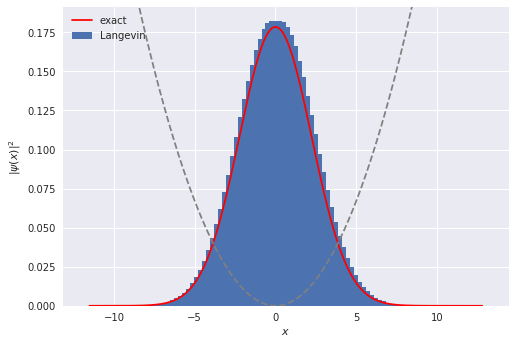

In [7]:
with plt.style.context('seaborn'):
    fig, ax = plt.subplots()
    
    # Langevin histogram.
    center = (edges[:-1] + edges[1:])/2.
    ax.bar(center, bins, align='center', label='Langevin')
    
    # ---
    
    # Expected result.
    x = np.linspace(np.min(center), np.max(center), 1000)
    wbar = param['omega']
    wfabs = (wbar/np.pi)**0.5 * np.exp(-wbar*x**2)
    ax.plot(x, wfabs, color='red', label='exact')
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$|\\psi(x)|^2$')
    ax.legend(loc='upper left')
    
    # ----
    
    # Potential, just as a guide.
    ax_potential = ax.twinx()
    ax_potential.plot(x, 0.5*wbar**2*x**2, color='gray', linestyle='dashed')
    
    ax_potential.grid(False)
    ax_potential.set_ylim(0, 2*np.max(wfabs))
    ax_potential.set_yticklabels([])

### Ground-state energy.

We can use the virial theorem to compute the ground-state energy: 

$\langle GS |\ p^2\ |GS \rangle$ = $\langle GS |\ x \frac{\partial V(x)}{\partial x}\ |GS \rangle$

so that the expectation value for the ground-state energy becomes

$\langle E \rangle = \frac{1}{\mathcal{Z}}\int\mathcal{D}x\ \left[\frac{x}{2}\frac{\partial V(x)}{\partial x} + V(x)\right]\ e^{-S[x]} 
= \frac{1}{\mathcal{Z}}\int\mathcal{D}x\ \omega^2 x^2 e^{-S[x]}$.

We can use the histogram to extract this information or directly sample $\langle x^2 \rangle$.

In [2]:
from scipy.optimize import curve_fit


def langevin_integration_energies(param):
    """ Takes a dictionary full of parameters and performs a Langevin integration. Returns a list of energies.
    """
    # Initialize the random state.
    np.random.seed(param['seed'])
    
    # Create the solution vector, i.e. the "field".
    n_tau = int(param['tau'] // param['d_tau'])
    
    # Calculate some recurring coefficients.
    sig = np.sqrt(2*param['d_tcl'])
    t = param['d_tcl']*(2. + param['omega']**2)
    
    # Get the size of the array.
    n_cl = int(param['tcl'] // param['d_tcl'])
    
    # Randomly initialize the position vector.
    x = np.random.normal(loc=0, scale=sig, size=n_tau)
    energies = np.zeros(n_cl)
    for k in range(0, n_cl):
        # Random vector.
        eta = np.random.normal(loc=0, scale=sig, size=n_tau)
        
        # Update the position vector.
        x = x*(1-t) + param['d_tcl']*(np.roll(x, 1) + np.roll(x, -1)) + eta
        
        # Calculate the observable.
        energies[k] = param['omega']**2 * np.dot(x, x)/n_tau
    
    return energies


def running_average(y):
    """ Returns a list with running averages for a given list of values.
    """
    r = np.zeros_like(y)
    r[0] = y[0]
    for k in range(1, len(y)):
        r[k] = (r[k-1]*k + y[k]) / (k+1)
    return r


def autocorrelation(y):
    """ Calculates the autocorrelation for a given list of values and estiamtes the autocorrelation time via an exponential fit.
    """
    # Find the next highest power of two, for zero-padding.
    n = int(2**np.ceil(np.log2(len(y))))
    
    # FFT with zero-padding.
    f = np.fft.fft(y - np.mean(y), n=2*n)
    
    # Autocorrelation of the (rightfully assumed) real input via
    # inverse FFT of the absolute square, normalized.
    acorr = np.fft.ifft(f * np.conjugate(f))[:len(y)].real / 4*n
    ac = acorr / acorr[0]

    # compute autocorrelation time by least-squares fit to the exponential decay.
    taf = lambda x, ta: np.exp(-x/ta)
    popt, pcov = curve_fit(taf, np.arange(len(ac)), ac)

    return popt[0], ac


def eval_data(y, warmup_rate=0.1):
    """ Returns mean and standard deviation for a given list of values, autocorrelation considered.
    """
    t_acorr, _ = autocorrelation(y)
    wc = int(len(y)*warmup_rate)
    uncorrelated_y = y[wc::int(t_acorr)]
    
    return np.mean(uncorrelated_y), np.std(uncorrelated_y) / np.sqrt(len(uncorrelated_y))

#### Measured values and running average.

In [28]:
param = {
    'tau' : 20.,         # Euclidean time
    'd_tau' : 0.01,      # Euclidean timestep (like Trotter step)

    'tcl' : 1000,        # Langevin integration time
    'd_tcl' : 0.005,     # Langevin integration step
    
    'omega': 0.5,          # Frequency of the harmonic oscillator
    'seed' : 342,         # Random seed to initialize the random number sequence
}
energies = langevin_integration_energies(param)
energies /= param['omega']

/opt/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


E = 0.48553036 +- 0.00029312


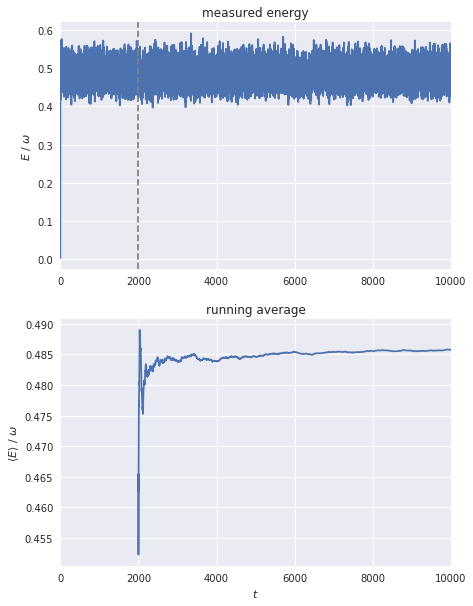

In [50]:
wr = 0.
wc = int(warmup_rate*len(energies))
ravg = running_average(energies[wc:])

avg, sig = eval_data(energies, warmup_rate=wr)
print('E = {:.8f} +- {:.8f}'.format(avg, sig))

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(2)
    fig.set_size_inches(7, 10)
    
    t = np.arange(0, len(energies))*param['d_tcl']
    ax[0].plot(t, energies)
    ax[0].set_xlim(0, param['tcl'])
    
    ax[0].axvline(t[wc], color='gray', linestyle='--')
    ax[0].set_title('measured energy')
    ax[0].set_ylabel('$E\ /\ \\omega$')
    
    # ---
    
    ax[1].plot(t[wc:], ravg)
    ax[1].set_xlim(0, param['tcl'])
    
    ax[1].set_title('running average')
    ax[1].set_xlabel('$t$')
    ax[1].set_ylabel('$\\langle E \\rangle\ /\ \\omega$')